# Microsoft GraphRAG Demo

GraphRAG is a knowledge graph-based approach to Retrieval Augmented Generation (RAG) that provides LLMs with complete understanding of a dataset at global and local levels. It does this by constructing a graph of entities & relationships which are then partitioned into hierarchical communities. At query time, LLM context is built using a combination of entity description vector search, graph traversals, community summaries and raw text. GraphRAG has two main search methods, Global Search & Local Search, where local is more entity driven and global relies more heavily on communities.

Graph construction:
* Entity and relationship extraction
* Post-process entity resolution
* Hierarchical network graph clustering
* Summarize each community and its constituents from the bottom-up

To learn more check out the Microsoft [blog post](https://www.microsoft.com/en-us/research/blog/graphrag-unlocking-llm-discovery-on-narrative-private-data/) and GraphRAG [paper](https://arxiv.org/pdf/2404.16130)

In [1]:
import os
import pandas as pd
import warnings
from IPython.display import Markdown
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from src.doc_store.cl_client  import CourtListenerClient
from src.graphrag.graphrag_manager import GraphRAGManager
from src.db.graph_memory.database import GraphMemory

## Demo Walkthrough

To try out GraphRAG we'll pull 10 legal opinions from Court Listener for the search terms "Liberty Mutual" and "coverage denial". This runs a full text search and not necessarily for cases involving Liberty directly.

In [3]:
cl_client = CourtListenerClient()
cl_res = cl_client.fetch_cases_by_query('"Liberty Mutual" "coverage denial"')
df = cl_res.to_pandas()

In [3]:
df = pd.read_parquet("./data/tables/cl_query_lm.parquet").head(10)

## Search Results

Follow the links and select `download_url` to view the opinion PDF, for example [Downey v. Johnson](https://www.mass.gov/doc/downey-v-johnson-22p0106/download)

In [5]:
Markdown(df[['publication_date', 'court', 'name', 'resource_uri']].to_markdown(index=False))

| publication_date   | court           | name                                                                      | resource_uri                                                 |
|:-------------------|:----------------|:--------------------------------------------------------------------------|:-------------------------------------------------------------|
| 2024-07-03         | Mass. App. Ct.  | Downey v. Johnson                                                         | https://www.courtlistener.com/api/rest/v3/opinions/10464069/ |
| 2024-07-03         | N.Y. App. Div.  | SMG Automotive Holdings, LLC v. Kings Automotive Holdings, LLC            | https://www.courtlistener.com/api/rest/v3/opinions/10464039/ |
| 2024-07-03         | Iowa Ct. App.   | MidAmerican Energy Company v. Knife River Midwest, LLC, d/b/a Knife River | https://www.courtlistener.com/api/rest/v3/opinions/10463915/ |
| 2024-07-02         | N.C. Ct. App.   | Jessey Sports, LLC v. Intercollegiate Men's Lacrosse Coaches Ass'n        | https://www.courtlistener.com/api/rest/v3/opinions/10454116/ |
| 2024-07-02         | Ga. Ct. App.    | WILLIAM HAYES v. KSP SERVICES, LLC                                        | https://www.courtlistener.com/api/rest/v3/opinions/10454490/ |
| 2024-07-01         | Ohio Ct. App.   | State v. Johnson                                                          | https://www.courtlistener.com/api/rest/v3/opinions/10453852/ |
| 2024-07-01         | Del. Super. Ct. | Getzler v. River Run Foods                                                | https://www.courtlistener.com/api/rest/v3/opinions/10454336/ |
| 2024-06-28         | Del. Super. Ct. | Hartree Natural Gas Storage, LLC v. Euclid Transactional, LLC             | https://www.courtlistener.com/api/rest/v3/opinions/10452882/ |
| 2024-06-28         | SCOTUS          | Loper Bright Enterprises v. Raimondo                                      | https://www.courtlistener.com/api/rest/v3/opinions/10452863/ |
| 2024-06-27         | Del. Super. Ct. | The Cigna Group v. XL Specialty Insurance Company                         | https://www.courtlistener.com/api/rest/v3/opinions/10433301/ |

## Knowledge Graph Construction

* Entity and relationship extraction
* Post-process entity resolution
* Hierarchical network graph clustering
* Summarize each community and its constituents from the bottom-up

Running GraphRAG via CLI results in 14 parquet files of entities, relationships, embeddings, and several mappings. Output also includes summaries for all communities and connected entities.

Note that this is an expensive process. The opinions are ~30-40 pages each. Processing all 10 cost ~$12.00.

## Knowledge Graph of 10 Legal Opinions

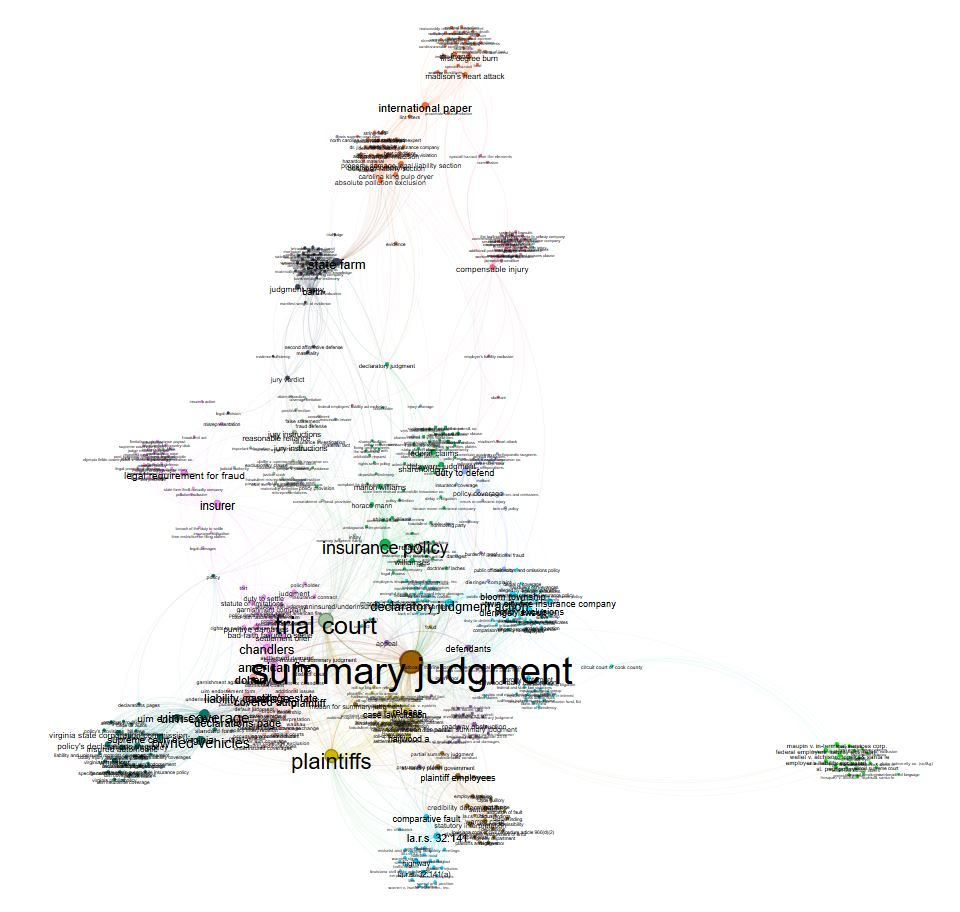

## Run Some Test Queries

* Read in data produced by GraphRAG

In [6]:
graph_rag = GraphRAGManager()

Processed 1,860 entities
Processed 2,630 relationships
Processed 776 text units
Processed 261 reports


### Example Entities

In [7]:
Markdown(graph_rag.entity_df.sample(5, random_state=4)[['type', 'title', 'description']].to_markdown(index=False))

| type                | title                          | description                                                                                                                                                               |
|:--------------------|:-------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| "COMPLAINT"         | "ADDITIONS UNDER CONSTRUCTION" | "Additions under construction are covered under the Business Personal Property type of coverage if not covered by other insurance."                                       |
| "DEFENDANT"         | "MUTUAL HOLDING COMPANY, INC." | "Mutual Holding Company, Inc. provides third-party claims administration services to Liberty Mutual’s Group members."                                                     |
| "STATUTE"           | "29 U.S.C. § 1001"             | "29 U.S.C. § 1001 is a statute quoted in the context of ERISA, emphasizing the provision of appropriate remedies, sanctions, and access to Federal courts."               |
| "CASE LAW CITATION" | "RUSSELL, 473 U.S. AT 146"     | "Russell, 473 U.S. at 146 is a case law citation referenced to support the argument that Congress did not intend to authorize other remedies not expressly incorporated." |
| "DEFENDANT"         | "WARREN HASKEL"                | Warren Haskel, represented by McDermott Will & Emery LLP based in New York, New York, is involved in a legal case as a defendant-appellant.                               |

### Example Relationships

In [8]:
Markdown(graph_rag.relationship_df.sample(5, random_state=2)[['source', 'target', 'description']].to_markdown(index=False))

| source                                                                     | target                                            | description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
|:---------------------------------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| "HARTFORD FIRE INSURANCE COMPANY"                                          | "MARSHALL DENNEHEY WARNER COLEMAN & GOGGIN, P.C." | "MARSHALL DENNEHEY WARNER COLEMAN & GOGGIN, P.C. is a law firm representing Hartford Fire Insurance Company."                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| "HOSANNA POLICY"                                                           | "CIVIL AUTHORITY PROVISION"                       | "The Civil Authority provision is a part of the Hosanna Policy."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| "FRIENDS OF THE EARTH, INC. V. LAIDLAW ENVIRONMENTAL SERVICES (TOC), INC." | "ARIZONANS FOR OFFICIAL ENGLISH V. ARIZONA"       | "Friends of the Earth, Inc. v. Laidlaw Environmental Services (TOC), Inc. quotes Arizonans for Official English v. Arizona regarding the doctrine of mootness."                                                                                                                                                                                                                                                                                                                                                                                         |
| "SUPERIOR COURT"                                                           | "MILLS"                                           | "The Superior Court adhered closely to its analysis in Mills for the choice-of-law analysis."                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| "HARTFORD"                                                                 | "MARYLAND LAW"                                    | Hartford, in its legal arguments, consistently references Maryland law to interpret and apply the term 'direct physical loss' within the context of insurance coverage disputes. Specifically, Hartford argues that 'direct physical loss' necessitates actual physical damage to property, a stance that has influenced its decision to deny claims. Furthermore, Hartford contends that Maryland law should govern all claims related to NETworks and Troika, indicating a broad application of this legal interpretation in its insurance practices. |

## Query 1 - Global Search
"Summarize the court's opinion of Liberty Mutual's handling of coverage denials"

In [26]:
result = await graph_rag.search_global("Summarize the court's opinion of Liberty Mutual's handling of coverage denials.")
Markdown(result.response)

# Summary of Court's Opinion on Liberty Mutual's Handling of Coverage Denials

## Background
Liberty Mutual Group, including its subsidiaries such as Liberty Mutual Fire Insurance Company, has been involved in a complex legal dispute with First State Orthopaedics, P.A. (FSO) regarding the enforceability of insurance policies and the use of billing code x553. This code was used to deny coverage for medical bills under Delaware Workers' Compensation Law [Data: Entities (582, 1632); Relationships (1098, 1099, 1100, 1101, 1102, 1103, +more)].

## Key Issues
### Use of Code x553
Liberty Mutual used billing code x553 to deny coverage, stating that the service was "not authorized by the case manager." This explanation was deemed insufficient and not meaningful under Delaware Workers' Compensation Law Section 2322F(e) [Data: Entities (1627); Relationships (2405, 2406, 2407, 2408, 2409, 2410, +more)].

### Legal Proceedings
Liberty Mutual defended the use of code x553, arguing that it complied with Section 2322F(e). However, the court found that the code did not provide a meaningful explanation for the denial of coverage, which is required by law [Data: Entities (1632); Relationships (2503, 2547, 2548)].

## Court's Findings
### Standing and Mootness
The court addressed Liberty Mutual's arguments regarding standing and mootness. Liberty argued that the case was moot because it had discontinued the use of code x553 before the lawsuit was filed and offered to enter into a consent judgment to never use the code again. However, the court found that Liberty's continued defense of the code suggested it could resume using it in the future, thus maintaining an ongoing controversy [Data: Sources (626, 603, 609, 629, 612, 611, 613, 614, 625, 630, 649, 651)].

### Uncorrected Claim Denials
The court noted that Liberty had not corrected 19 claim denials that used code x553, which contributed to the ongoing injury and controversy. This failure to correct past denials was a significant factor in the court's decision [Data: Entities (1707); Relationships (2503)].

### Declaratory Judgment
The court issued a declaratory judgment stating that the response to requests to pay medical bills under Delaware Workers' Compensation Law must be meaningful. It declared that code x553 did not comply with this requirement, thus supporting FSO's position [Data: Sources (612, 613, 614)].

## Conclusion
The court's opinion highlighted several critical points regarding Liberty Mutual's handling of coverage denials:
- The use of code x553 was found to be non-compliant with legal requirements for meaningful explanations.
- Liberty's defense of the code, despite its discontinuation, suggested the potential for future use, maintaining the controversy.
- The failure to correct past claim denials using code x553 contributed to the ongoing legal dispute.

These findings underscore the importance of providing clear and meaningful explanations for coverage denials and the legal implications of failing to do so.

## Query 2 - Local Search
"How has Liberty Mutual's use of Code x553 influenced the legal proceedings?"

In [71]:
result = await graph_rag.search_local("How has Liberty Mutual's use of Code x553 influenced the legal proceedings?")
Markdown(result.response)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:graphrag.query.structured_search.local_search.mixed_context:Reached token limit - reverting to previous context state
INFO:graphrag.query.structured_search.local_search.search:GENERATE ANSWER: 1720316787.9448414. QUERY: How has Liberty Mutual's use of Code x553 influenced the legal proceedings?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Influence of Liberty Mutual's Use of Code X553 on Legal Proceedings

## Introduction

The use of Code X553 by Liberty Mutual has significantly influenced the legal proceedings involving First State Orthopaedics (FSO) and Liberty. This billing code, used in the context of Delaware's Workers' Compensation Law, has been central to the dispute, affecting various aspects of the litigation, including legal strategies, court decisions, and broader implications for insurance practices.

## Central Role of Code X553

Code X553 was used by Liberty to deny coverage for medical services, citing that the services were "not authorized by the case manager" [Data: Entities (1627); Sources (594)]. This denial method was contested by FSO, which argued that the explanation provided by Code X553 was not meaningful and did not comply with Delaware Workers' Compensation Law Section 2322F(e) [Data: Entities (1626); Sources (612, 596)].

## Legal Proceedings and Court Decisions

### Summary Judgment and Standing

Liberty filed a Motion for Summary Judgment in March 2022, arguing issues related to standing, mootness, and the statute of limitations [Data: Entities (1660); Sources (611)]. The Superior Court denied this motion, concluding that FSO had standing due to the ongoing injury from 19 uncorrected claim denials and Liberty's unwillingness to admit a violation of Section 2322F(e) [Data: Entities (1660); Sources (612, 614)].

### Declaratory Judgment

The Superior Court entered a declaratory judgment stating that Code X553 did not provide a meaningful explanation for denial and thus did not comply with Delaware Workers' Compensation Law [Data: Entities (85); Sources (614, 615)]. This judgment was pivotal in affirming FSO's claims and influencing the legal strategies of both parties.

### Class Certification

FSO's attempt to gain class certification under Rule 23(b)(2) was denied by the Superior Court. The court reasoned that since Liberty had ceased using Code X553, a declaratory judgment would suffice without the need for class certification [Data: Entities (1656); Sources (611)].

## Liberty's Defense and Adjustments

Liberty defended the use of Code X553 by arguing its compliance with Section 2322F(e) and asserting that the code provided a meaningful explanation for denial [Data: Entities (1632); Sources (612, 596)]. Despite this defense, Liberty upgraded its bill review software in August 2018, which no longer included Code X553, indicating a shift in their approach [Data: Entities (1632); Sources (598)].

## Broader Implications

### Impact on Patients and Healthcare Providers

The dispute over Code X553 has broader implications for patients and healthcare providers in Delaware. The outcome of this case could influence how insurance claims are handled and contested, emphasizing the need for clear and fair claim denial processes [Data: Entities (1626); Sources (594)].

### Legal Precedents and Insurance Practices

The legal proceedings surrounding Code X553 have set important precedents regarding the interpretation and application of workers' compensation laws. The court's decisions highlight the necessity for insurance carriers to provide meaningful explanations for claim denials, potentially leading to changes in insurance practices and policies [Data: Entities (1627, 1632); Sources (612, 614, 615)].

## Conclusion

Liberty Mutual's use of Code X553 has profoundly influenced the legal proceedings with FSO, shaping court decisions, legal strategies, and broader implications for insurance practices. The case underscores the importance of compliance with statutory requirements and the need for transparent and meaningful communication in insurance claim denials.

## Query 3 - Local Search
"How do the coverage rulings specifically impact Liberty Mutual? What risks (financial or process-related) exist and how can the carrier best mitigate them?"

In [67]:
result = await graph_rag.search_local(
    "How do the coverage rulings specifically impact Liberty Mutual? What risks (financial or process-related) exist and how can the carrier best mitigate them?"
)
Markdown(result.response)

# Impact of Coverage Rulings on Liberty Mutual

## Overview

Liberty Mutual is currently navigating a complex legal landscape shaped by various coverage rulings. These rulings have significant implications for the company's financial stability, operational processes, and legal strategies. This report delves into the specific impacts of these rulings, the associated risks, and the best practices for mitigating these risks.

## Specific Impacts of Coverage Rulings

### Interpretation of 'Direct Physical Loss'

One of the most critical coverage rulings involves the interpretation of 'direct physical loss.' Courts have generally ruled that COVID-19 does not constitute 'direct physical loss,' which limits the scope of claims Liberty Mutual may need to cover. This precedent could significantly reduce the number of pandemic-related claims the company must pay out, thereby mitigating immediate financial exposure [Data: Reports (156, 165, 163, 160, 166)].

### Uninsured Motorist (UM) Coverage

The ruling in 'Thounsavath, 2018 IL 122558' reinforces that if an individual is considered insured for liability purposes, they automatically qualify for UM coverage. This decision prevents insurance companies from denying UM coverage based on conflicting policy terms, thereby upholding statutory protections for insured individuals. This ruling impacts how Liberty Mutual's policies are interpreted and enforced, potentially leading to increased payouts and higher reserves for potential claims [Data: Reports (185, 180, 182)].

### Delaware Workers' Compensation Law

Liberty Mutual is involved in a multifaceted legal dispute concerning the use of billing Code X553 under Delaware Workers' Compensation Law. The outcomes of these legal battles could set important precedents for how insurance denials are handled and the necessary compliance with statutory requirements. This practice could lead to legal challenges, highlighting the importance of these documents in the operational and compliance landscape of the group [Data: Reports (143, 142, 34)].

### Interpretation of Policy Terms

The coverage rulings also impact Liberty Mutual by setting legal precedents that could influence how similar insurance policies are interpreted in the future. This includes the interpretation of terms like 'sporting equipment' and 'fixtures,' which have broad implications for coverage claims and liability [Data: Reports (227, 239, 238, 236, 233)].

### Jurisdictional Implications

The Superior Court's decision in Mills Ltd. Partnership v. Liberty Mutual Insurance Co. established that Delaware has the most significant relationship with the risks insured by a D&O policy. This ruling impacts Liberty Mutual by setting a precedent for how D&O policies are interpreted in future legal disputes, emphasizing the importance of jurisdiction in legal determinations [Data: Reports (276)].

## Financial and Process-Related Risks

### Financial Risks

1. **Increased Litigation Costs and Claim Payouts**: Financial risks for Liberty Mutual include potential increases in litigation costs and claim payouts if courts were to rule differently in future cases. The current rulings favoring insurers in denying COVID-19 related claims help mitigate immediate financial exposure, but ongoing legal battles could alter this landscape [Data: Reports (156, 165, 163, 160, 166)].

2. **Potential Liabilities from UM Coverage**: Broader interpretations of UM coverage could lead to increased payouts and higher reserves for potential claims. This could significantly impact the company's financial stability [Data: Reports (180, 182, 185)].

3. **Liabilities from Workers' Compensation Claims**: The controversy surrounding 'Code x553' and its alleged contravention of sections of the Delaware Workers’ Compensation Code raises questions about the legality and ethicality of such denials. This could have broader implications for Liberty Mutual’s reputation and regulatory compliance [Data: Reports (34)].

### Process-Related Risks

1. **Need for Policy Language Updates**: Process-related risks involve the need for Liberty Mutual to continuously update and align their policy language with prevailing legal interpretations to avoid ambiguities that could lead to disputes. Ensuring clear definitions and exclusions in policy terms is crucial to mitigate these risks [Data: Reports (156, 165, 163, 160, 166)].

2. **Compliance with Judicial Interpretations**: The need to update policy language and claims processing procedures to ensure compliance with judicial interpretations and statutory requirements is essential. Failure to do so could result in legal challenges and penalties [Data: Reports (180, 182, 185)].

3. **Jurisdictional Considerations**: The ruling underscores the need for Liberty Mutual to carefully consider the choice-of-law provisions in their policies, as Delaware law will likely be applied in disputes involving Delaware-incorporated companies. This could affect the interpretation of policy terms and the outcome of coverage disputes [Data: Reports (276)].

## Mitigation Strategies

### Regular Policy Reviews and Updates

To mitigate these risks, Liberty Mutual should regularly review and update their policy language to align with current legal standards and judicial interpretations. This includes adopting clearer and more precise language in their insurance policies and utilizing authoritative sources like dictionaries and legal texts for defining terms [Data: Reports (180, 182, 185, 243, 230, 242)].

### Comprehensive Training Programs

Implementing comprehensive training programs for claims adjusters on the latest legal requirements and best practices can help ensure compliance and reduce the risk of legal disputes. This proactive approach can help in minimizing potential liabilities and improving operational efficiency [Data: Reports (180, 182, 185)].

### Enhanced Communication and Documentation

Liberty Mutual can also mitigate risks by enhancing communication with policyholders about coverage limits and exclusions, particularly in relation to pandemic-related claims. Clear and transparent communication can reduce the likelihood of disputes and improve customer trust [Data: Reports (156, 165, 163, 160, 166)].

### Proactive Legal Strategies

Engaging in proactive legal reviews and consultations to stay ahead of potential legal challenges is crucial. This includes closely monitoring legal developments and court rulings related to insurance coverage to stay informed about emerging legal trends and adjust policies and practices accordingly [Data: Reports (227, 239, 244, 245)].

### Internal Audit Systems

Implementing a robust internal audit system to regularly review and update billing codes and practices could help in maintaining compliance and avoiding future legal challenges. Ensuring that all administrative practices align with legal and regulatory requirements is essential for mitigating process-related risks [Data: Reports (32, 34)].

## Conclusion

The coverage rulings have far-reaching implications for Liberty Mutual, impacting both financial stability and operational processes. By adopting a proactive approach to policy reviews, training, communication, and legal strategies, Liberty Mutual can effectively mitigate these risks and navigate the complex legal landscape.

### Example of 'sources'

In [68]:
reports_df = result.context_data["reports"]

,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,309,# FSO vs. Liberty: Legal Dispute Over Workers'...,3,7.5,FSO vs. Liberty: Legal Dispute Over Workers' C...,The impact severity rating is high due to the ...,The community centers around First State Ortho...,[{'explanation': 'FSO has initiated a legal ba...,"{\n ""title"": ""FSO vs. Liberty: Legal Disput...",761d42b8-4215-462e-a73e-5da4f20c7d1e
1,310,# Legal Disputes Involving Insurance Claims an...,3,7.5,Legal Disputes Involving Insurance Claims and ...,The impact severity rating is relatively high ...,This report focuses on a series of legal compl...,"[{'explanation': 'First State Orthopaedics, P....","{\n ""title"": ""Legal Disputes Involving Insu...",f56048fe-b91f-4784-a9a7-50c2cf8271c4
2,311,# Liberty and Code X553 Legal Dispute\n\nThe c...,3,7.5,Liberty and Code X553 Legal Dispute,The impact severity rating is high due to the ...,"The community centers around Liberty, an insur...",[{'explanation': 'Liberty has been actively de...,"{\n ""title"": ""Liberty and Code X553 Legal D...",6afaf0e9-111d-4260-8338-1ac52a9e6717
3,312,# Section 2322F(e) and Coverage Denial Interpr...,3,7.5,Section 2322F(e) and Coverage Denial Interpret...,The impact severity rating is relatively high ...,This report focuses on the legal interpretatio...,[{'explanation': 'Section 2322F(e) is pivotal ...,"{\n ""title"": ""Section 2322F(e) and Coverage...",69b7d134-68bf-4e40-9917-4b24ffc6086e
4,313,# Hosanna vs. Hartford: Theatrical Insurance D...,3,7.5,Hosanna vs. Hartford: Theatrical Insurance Dis...,The impact severity rating is relatively high ...,This report examines the complex legal and ins...,[{'explanation': 'Hosanna is engaged in a lega...,"{\n ""title"": ""Hosanna vs. Hartford: Theatri...",a8f4a61c-686f-4ae5-b0cf-e784943dabb4
...,...,...,...,...,...,...,...,...,...,...
331,13,# Superior Court and RSUI: Legal Dynamics in I...,0,8.5,Superior Court and RSUI: Legal Dynamics in Ins...,The impact severity rating is high due to the ...,This report delves into the intricate legal in...,[{'explanation': 'The Superior Court plays a p...,"{\n ""title"": ""Superior Court and RSUI: Lega...",211c8749-86fd-4c91-b1c1-5c3206178e6d
332,2,# Hartford and Theatrical Insurance Disputes\n...,0,7.5,Hartford and Theatrical Insurance Disputes,The impact severity rating is relatively high ...,This report examines the complex legal interac...,[{'explanation': 'The interpretation of 'direc...,"{\n ""title"": ""Hartford and Theatrical Insur...",70287752-8d64-4412-82d2-98ebd03794b4
333,3,# Direct Auto Insurance Co. and Uninsured Moto...,0,7.5,Direct Auto Insurance Co. and Uninsured Motori...,The impact severity rating is high due to the ...,This report focuses on the legal disputes invo...,[{'explanation': 'Direct Auto Insurance Co. is...,"{\n ""title"": ""Direct Auto Insurance Co. and...",7310a69d-b009-4fbb-aad1-9a583a15899a
334,7,# United Behavioral Health and ERISA Complianc...,0,8.5,United Behavioral Health and ERISA Compliance ...,The impact severity rating is high due to the ...,This report delves into the complex legal land...,[{'explanation': 'United Behavioral Health (UB...,"{\n ""title"": ""United Behavioral Health and ...",ac519157-fa03-40f6-be63-040e86dbd486


### Community Summary Example

In [71]:
Markdown(report_df[report_df["community"]=='34']["full_content"].tolist()[0])

# Liberty Mutual's Group and Explanation of Benefits Forms

This report examines the relationships and activities within Liberty Mutual’s Group, focusing on the use of 'Code x553' in Explanation of Benefits forms to deny workers' compensation claims. Mutual Holding Company, Inc. plays a significant role by providing third-party claims administration services to the group.

## Explanation of Benefits Forms and their impact

The Explanation of Benefits forms issued by Liberty Mutual’s Group using 'Code x553' have been a central element in denying coverage for workers’ compensation bills. This practice has significant implications for the financial and legal standing of the entity, as it directly affects the compensation of workers. The use of specific codes to deny claims could potentially lead to legal challenges, highlighting the importance of these documents in the operational and compliance landscape of the group [Data: Entities (1625), Relationships (2461, 2462, 2460)].

## Role of Mutual Holding Company, Inc.

Mutual Holding Company, Inc. provides crucial administrative services to Liberty Mutual’s Group, which includes the issuance of the controversial Explanation of Benefits forms. This entity’s role is pivotal in the administration of claims and potentially influences the group’s compliance with regulatory standards. The relationship between Mutual Holding Company, Inc. and Liberty Mutual’s Group underscores the interconnected nature of their operations and the potential risks associated with their administrative practices [Data: Entities (1623, 1624), Relationships (2459)].

## Controversy surrounding 'Code x553'

The use of 'Code x553' in the Explanation of Benefits forms has been a point of contention, particularly with FSO arguing that this practice contravenes sections of the Delaware Workers’ Compensation Code. This dispute not only highlights the specific operational practices of Liberty Mutual’s Group but also raises questions about the legality and ethicality of such denials. The controversy could have broader implications for the group’s reputation and regulatory compliance [Data: Relationships (2461, 2462)].

### Context Entities Example

In [79]:
Markdown(relationship_df[relationship_df["human_readable_id"].isin(['2461', '2462'])][['source', 'target', 'description', 'human_readable_id']].to_markdown())

|      | source                          | target      | description                                                                                                                                            |   human_readable_id |
|-----:|:--------------------------------|:------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------:|
| 2461 | "EXPLANATION OF BENEFITS FORMS" | "FSO"       | "FSO argues that the denial of coverage in the Explanation of Benefits forms contravenes certain sections of the Delaware Workers’ Compensation Code." |                2461 |
| 2462 | "EXPLANATION OF BENEFITS FORMS" | "CODE X553" | "Code x553 is used in the Explanation of Benefits forms to deny coverage of workers’ compensation bills."                                              |                2462 |

### Map Back to Raw Text

In [82]:
relationship_df[relationship_df["human_readable_id"].isin(['2461', '2462'])]['text_unit_ids']

2461    [60937e9dc6e07123c03d887841bd5ffd]
2462    [60937e9dc6e07123c03d887841bd5ffd]
Name: text_unit_ids, dtype: object

In [85]:
Markdown(text_unit_df[text_unit_df["id"]=="60937e9dc6e07123c03d887841bd5ffd"]["text"].tolist()[0])

 Mutual Holding Company, Inc., providing third-party claims

administration services to Liberty Mutual’s Group members, including the other

Appellants.5 Collectively, Appellants are referred to as “Liberty.”

          In 2017 and 2018, Liberty routinely issued Explanation of Benefits forms to

FSO using “Code x553.” Those forms purported to deny coverage of workers’

compensation bills for procedures that FSO performed.6            The Explanation of

Benefits generated by Code x553 stated:

          THIS SERVICE NOT AUTHORIZED BY CASE MANAGER.
          PLEASE CONTACT THE CASE MANAGER FOR FURTHER
          INFORMATION.7

          FSO argues that this denial contravenes certain sections of the Delaware

Workers’ Compensation Code because the response fails to provide a meaningful

explanation for the reason for the denial.8 FSO relies on three sections of Title 19 to

support its position. First, 19 Del. C. § 2362(b) mandates that


3
    Id. at A368.
4
    Id.
5
    Id. at A368–69.
6
    Id. at A370.
7
    Id.
8
    Id. at A369–70.

                                           3
           [a]ll medical expenses shall be paid within 30 days after bills and
           documentation for said expenses are received by the employer or its
           insurance carrier for payment, unless the carrier or self

## Cost for the above 3 queries

In [64]:
print(f"LLM calls: {result.llm_calls}. LLM tokens: {result.prompt_tokens}")

LLM calls: 12. LLM tokens: 134489
